# Quantum analytic decent

In [3]:
#Importiere die notwendigen Packages
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
import copy

Initialisieren

In [4]:
warnings.filterwarnings("ignore")

#Setze den seed, damit die Pseudozufallsprozesse reproduzierbar ablaufen
np.random.seed(0)

Definiere ein Device mit dem Namen "dev" und zwei Qbits.
Definiere eine Quantenfunktion mit dem Argument "parameters". Auf beiden wires findet eine Rotation um die X-Achse um den Winkel parameters[0] bzw. parameters[1] statt. Die Ausgabe der Funktion sind die mit einem Pauli Z Gate ausgewerteten Wires. Die Funktion wird mit @qml.qnode() in eine QNode umgewandelt.

In [5]:
# Create a device with 2 qubits.
dev = qml.device("default.qubit", wires=2)

# Define the variational form V and observable M and combine them into a QNode.
@qml.qnode(dev, diff_method="parameter-shift", max_diff=2)
def circuit(parameters):
    qml.RX(parameters[0], wires=0)
    qml.RX(parameters[1], wires=1)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

Werte für je einen fixen Parameter (3.3 bzw. 0.5) die Funktion für den jeweils anderen Parameter aus dem Intervall [0, 2$\pi$] an num-samples = 50 gleichmäßig verteilten Punkten aus.
Plotte die Ergebnisse für beide Parameter mit dem varierten Parameter theta auf der X-Achse und der Energie (Ausgabe der Funktion circuit) auf der Y-Achse.

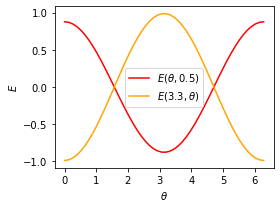

In [6]:
# Create 1D sweeps through parameter space with the other parameter fixed.
num_samples = 50

# Fix a parameter position.
parameters = np.array([3.3, 0.5], requires_grad=True)

theta_func = np.linspace(0, 2 * np.pi, num_samples)
C1 = [circuit(np.array([theta, parameters[1]])) for theta in theta_func]
C2 = [circuit(np.array([parameters[0], theta])) for theta in theta_func]

# Show the sweeps.
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(theta_func, C1, label="$E(\\theta, 0.5)$", color="r")
ax.plot(theta_func, C2, label="$E(3.3, \\theta)$", color="orange")
ax.set_xlabel("$\\theta$")
ax.set_ylabel("$E$")
ax.legend()
plt.tight_layout()

Werte die Funktion in einem Gitter aus, wobei zur besseren Ansicht ein Kreis mit Radius 2 um den Punkt (2$\pi$,0) nicht ausgewertet wird. Das Ergebnis wird in einem Surfice-Plot zusammen mit den Kurven aus dem vorheringen Plot dargestellt.

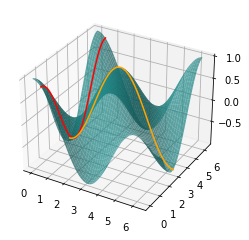

In [10]:
# Create a 2D grid and evaluate the energy on the grid points.
# We cut out a part of the landscape to increase clarity.
X, Y = np.meshgrid(theta_func, theta_func)
Z = np.zeros_like(X)
for i, t1 in enumerate(theta_func):
    for j, t2 in enumerate(theta_func):
        # Cut out the viewer-facing corner
        if (2 * np.pi - t2) ** 2 + t1 ** 2 > 4:
            Z[i, j] = circuit([t1, t2])
        else:
            X[i, j] = Y[i, j] = Z[i, j] = np.nan

# Show the energy landscape on the grid.
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(4, 4))
surf = ax.plot_surface(X, Y, Z, label="$E(\\theta_1, \\theta_2)$", alpha=0.7, color="#209494")
line1 = ax.plot(
    [parameters[1]] * num_samples,
    theta_func,
    C1,
    label="$E(\\theta_1, \\theta_2^{(0)})$",
    color="r",
    zorder=100,
)
line2 = ax.plot(
    theta_func,
    [parameters[0]] * num_samples,
    C2,
    label="$E(\\theta_1^{(0)}, \\theta_2)$",
    color="orange",
    zorder=100,
)

Definiere eine Funktion, die als Input eine Funktion und deren Parameter nimmt und die Koeffizienten für die Näherung der Funktion für das klassische Model bei diesen Parametern berechnet.

In [11]:
def get_model_data(fun, params):
    """Computes the coefficients for the classical model, E^(A), E^(B), E^(C), and E^(D)."""
    num_params = len(params)

    # E_A contains the energy at the reference point
    E_A = fun(params)

    # E_B contains the gradient.
    E_B = qml.grad(fun)(params)

    hessian = qml.jacobian(qml.grad(fun))(params)

    # E_C contains the slightly adapted diagonal of the Hessian.
    E_C = np.diag(hessian) + E_A / 2

    # E_D contains the off-diagonal parts of the Hessian.
    # We store each pair (k, l) only once, namely the upper triangle.
    E_D = np.triu(hessian, 1)

    return E_A, E_B, E_C, E_D

Nutze die zuvor definierten Funktionen, um die Koeffizienten für das klassische Model für zwei zufällige Parameter aus dem Intervall [0,2$\pi$] zu berechnen.

In [12]:
parameters = np.random.random(2, requires_grad=True) * 2 * np.pi
print(f"Random parameters (params): {parameters}")
coeffs = get_model_data(circuit, parameters)
print(
    f"Coefficients at params:",
    f" E_A = {coeffs[0]}",
    f" E_B = {coeffs[1]}",
    f" E_C = {coeffs[2]}",
    f" E_D = {coeffs[3]}",
    sep="\n",
)

Random parameters (params): [3.44829694 4.49366732]
Coefficients at params:
 E_A = 0.20685619228992974
 E_B = [-0.06551083 -0.9306212 ]
 E_C = [-0.1034281 -0.1034281]
 E_D = [[0.         0.29472535]
 [0.         0.        ]]


Definiere die Kostenfunktion im klassischen Model für die Parameter und zugehörigen Koeffizienten.

In [14]:
def model_cost(params, E_A, E_B, E_C, E_D):
    """Compute the model cost for relative parameters and given model data."""
    A = np.prod(np.cos(0.5 * params) ** 2)

    # For the other terms we only compute the prefactor relative to A
    B_over_A = 2 * np.tan(0.5 * params)
    C_over_A = B_over_A ** 2 / 2
    D_over_A = np.outer(B_over_A, B_over_A)

    all_terms_over_A = [
        E_A,
        np.dot(E_B, B_over_A),
        np.dot(E_C, C_over_A),
        np.dot(B_over_A, E_D @ B_over_A),
    ]

    cost = A * np.sum(all_terms_over_A)

    return cost

Vergleiche die Quantenfunktion und die Modelfunktion an den Parametern, um zu überprüfen, dass die Modelfuntion an diese Stelle exakt ist.

In [15]:
# Compute the circuit at parameters (This value is also stored in E_A=coeffs[0])
E_original = circuit(parameters)
# Compute the model at parameters by plugging in relative parameters 0.
E_model = model_cost(np.zeros_like(parameters), *coeffs)
print(
    f"The cost function at parameters:",
    f"  Model:    {E_model}",
    f"  Original: {E_original}",
    sep="\n",
)
# Check that coeffs[0] indeed is the original energy and that the model is correct at 0.
print(f"E_A and E_original are the same: {coeffs[0]==E_original}")
print(f"E_model and E_original are the same: {E_model==E_original}")

The cost function at parameters:
  Model:    0.20685619228992974
  Original: 0.20685619228992974
E_A and E_original are the same: True
E_model and E_original are the same: True


Vergleiche die Quantenfunktion und die Modelfunktion an einem Punkt der auf beiden Parametern um unteschiedliche zufällige Werte au [0, 0.1] verschoben ist.

In [16]:
# Obtain a random shift away from parameters
shift = 0.1 * np.random.random(2)
print(f"Shift parameters by the vector {np.round(shift, 4)}.")
new_parameters = parameters + shift
# Compute the cost function and the model at the shifted position.
E_original = circuit(new_parameters)
E_model = model_cost(shift, *coeffs)
print(
    f"The cost function at parameters:",
    f"  Model:    {E_model}",
    f"  Original: {E_original}",
    sep="\n",
)
print(f"E_model and E_original are the same: {E_model==E_original}")

Shift parameters by the vector [0.0603 0.0545].
The cost function at parameters:
  Model:    0.1525605564236959
  Original: 0.1526096460515975
E_model and E_original are the same: False


Definiere eine Funktion, die die Funktion, die Modelfunktion und die Differenz der beiden Funktionen plottet.

In [18]:
# We actually make the plotting a function because we will reuse it below.
def plot_cost_and_model(f, model, params, shift_radius=5 * np.pi / 8, num_points=20):
    """Plot a function and a model of the function as well as its deviation."""

    coords = np.linspace(-shift_radius, shift_radius, num_points)
    X, Y = np.meshgrid(coords + params[0], coords + params[1])

    # Compute the original cost function and the model on the grid.
    Z_original = np.array([[f(params + np.array([t1, t2])) for t2 in coords] for t1 in coords])
    Z_model = np.array([[model(np.array([t1, t2])) for t2 in coords] for t1 in coords])

    # Prepare sampled points for plotting rods.
    shifts = [-np.pi / 2, 0, np.pi / 2]
    samples = []
    for s1, s2 in product(shifts, repeat=2):
        shifted_params = params + np.array([s1, s2])
        samples.append([*(params+np.array([s2, s1])), f(shifted_params)])

    # Display landscapes incl. sampled points and deviation.
    alpha = 0.6
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(10, 4))
    green = "#209494"
    orange = "#ED7D31"
    red = "xkcd:brick red"
    surf = ax0.plot_surface(X, Y, Z_original, color=green, alpha=alpha)
    ax0.set_title("Original energy and samples")
    ax1.plot_surface(X, Y, Z_model, color=orange, alpha=alpha)
    ax1.set_title("Model energy")
    ax2.plot_surface(X, Y, Z_original - Z_model, color=red, alpha=alpha)
    ax2.set_title("Deviation")
    for s in samples:
        ax0.plot([s[0]] * 2, [s[1]] * 2, [np.min(Z_original) - 0.2, s[2]], color="k")
    for ax, z in zip((ax0, ax1), (f(params), model(0 * params))):
        ax.plot([params[0]] * 2, [params[1]] * 2, [np.min(Z_original) - 0.2, z], color="k")
        ax.scatter([params[0]], [params[1]], [z], color="k", marker="o")
    plt.tight_layout(pad=2, w_pad=2.5)


Plotte die Funktion, die Modelfunktion und deren Differenz.

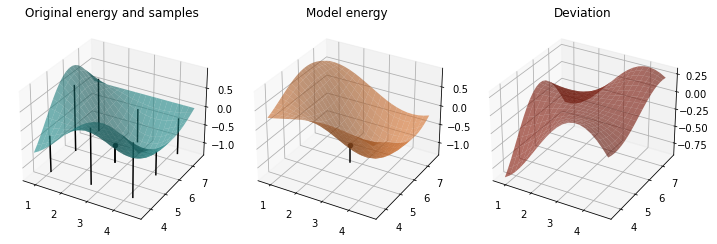

In [19]:
# Get some fresh random parameters and the model coefficients
parameters = np.random.random(2, requires_grad=True) * 2 * np.pi
coeffs = get_model_data(circuit, parameters)

# Define a mapped model that has the model coefficients fixed.
mapped_model = lambda params: model_cost(params, *coeffs)
plot_cost_and_model(circuit, mapped_model, parameters)

[Pennylane Tutorial](https://pennylane.ai/qml/demos/tutorial_quantum_analytic_descent.html)